**臺灣近年交通事故件數**
==

載入所需的 library

In [1]:
# import 所需的 library
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from statsmodels.tsa.seasonal import DecomposeResult, seasonal_decompose
import pmdarima as pm
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from xgboost import plot_importance, plot_tree
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 不顯示 warning 訊息
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

# 指定中文字型為微軟正黑體
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']  
plt.rcParams['axes.unicode_minus'] = False  

載入第 1 個資料集:**臺灣近年交通事故件數**


In [2]:
dat = pd.read_csv("C:\\Users\\user\\OneDrive\\桌面\\專案資料\\交通狀況\\事故件數統計.csv", thousands=',')

dat = dat.dropna()
year_month = list()
for i in range(231):
    if i <= 95:
        if i%12 < 9:
            year_month.append(str(int(dat.統計期[i][:2])+1911) + "-" + "0" + dat.統計期[i][4:5])
        else:
            year_month.append(str(int(dat.統計期[i][:2])+1911) + "-" + dat.統計期[i][4:6])
    else:
        if i%12 < 9:
            year_month.append(str(int(dat.統計期[i][:3])+1911) + "-" + "0" + dat.統計期[i][5:6])
        else:
            year_month.append(str(int(dat.統計期[i][:3])+1911) + "-" + dat.統計期[i][5:7])

dat['date'] = pd.Series(year_month)
dat = dat.rename(columns = {'件數':'amount'})
dat = dat[['date','amount']]
dat['date'] = pd.to_datetime(dat['date']) + pd.offsets.MonthEnd(0)

畫出事件數量對於時間的趨勢圖

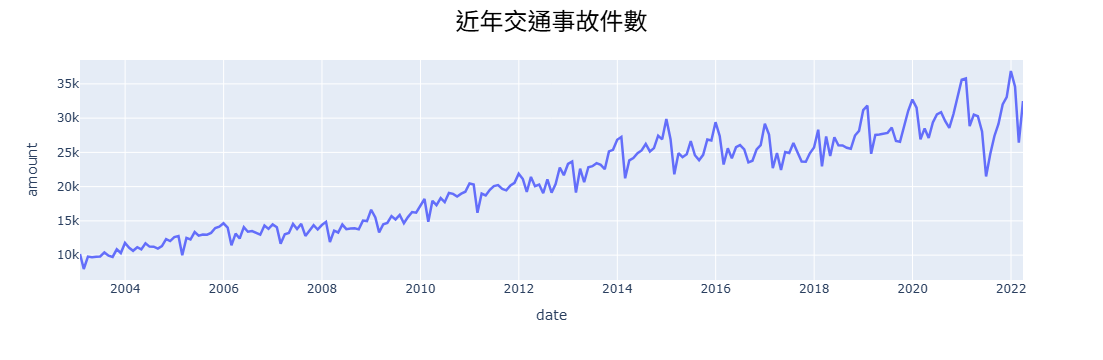

In [14]:
fig = px.line(dat, x='date', y="amount")
fig.update_traces(line=dict(width=2.5))
fig.update_layout(
    title=dict(
        text="近年交通事故件數", # Make it bold
        font=dict(size=24,color = 'black'), # Change font size and color
        x=0.5, # Center the title horizontally
        xanchor='center'
    )
)
fig.show()

可以很明顯地看到事故件數有隨著時間增加的趨勢，並且具有季節性的影響，於圖形當中可以發現在 2021 年 6 月時數量有明顯下降，可以很輕易地聯想應是當時新冠疫情 3 級警戒的影響，出門人數大量減少因此連帶事故件數也大幅減少。
以下，為了更明顯地分辨出先前提到的趨勢以及季節性影響，我嘗試使用函數 (seasonal_decompose) 並畫出季節性分解 (seasonal decomposition) 的結果。

In [4]:
def plot_seasonal_decompose(result:DecomposeResult, dates:pd.Series=None, title="季節性分解"):
    x_values = dates if dates is not None else np.arange(len(result.observed))
    return (
        make_subplots(
            rows=4,
            cols=1,
            subplot_titles=["原始資料", "趨勢", "季節性影響", "殘差"],
        )
        .add_trace(
            go.Scatter(x=x_values, y=result.observed, mode="lines", name='原始資料'),
            row=1,
            col=1,
        )
        .add_trace(
            go.Scatter(x=x_values, y=result.trend, mode="lines", name='趨勢'),
            row=2,
            col=1,
        )
        .add_trace(
            go.Scatter(x=x_values, y=result.seasonal, mode="lines", name='季節性影響'),
            row=3,
            col=1,
        )
        .add_trace(
            go.Scatter(x=x_values, y=result.resid, mode="lines", name='殘差'),
            row=4,
            col=1,
        )
        .update_layout(
            height=900, title=f'<b>{title}</b>', margin={'t':100}, title_x=0.5, showlegend=False
        )
    )

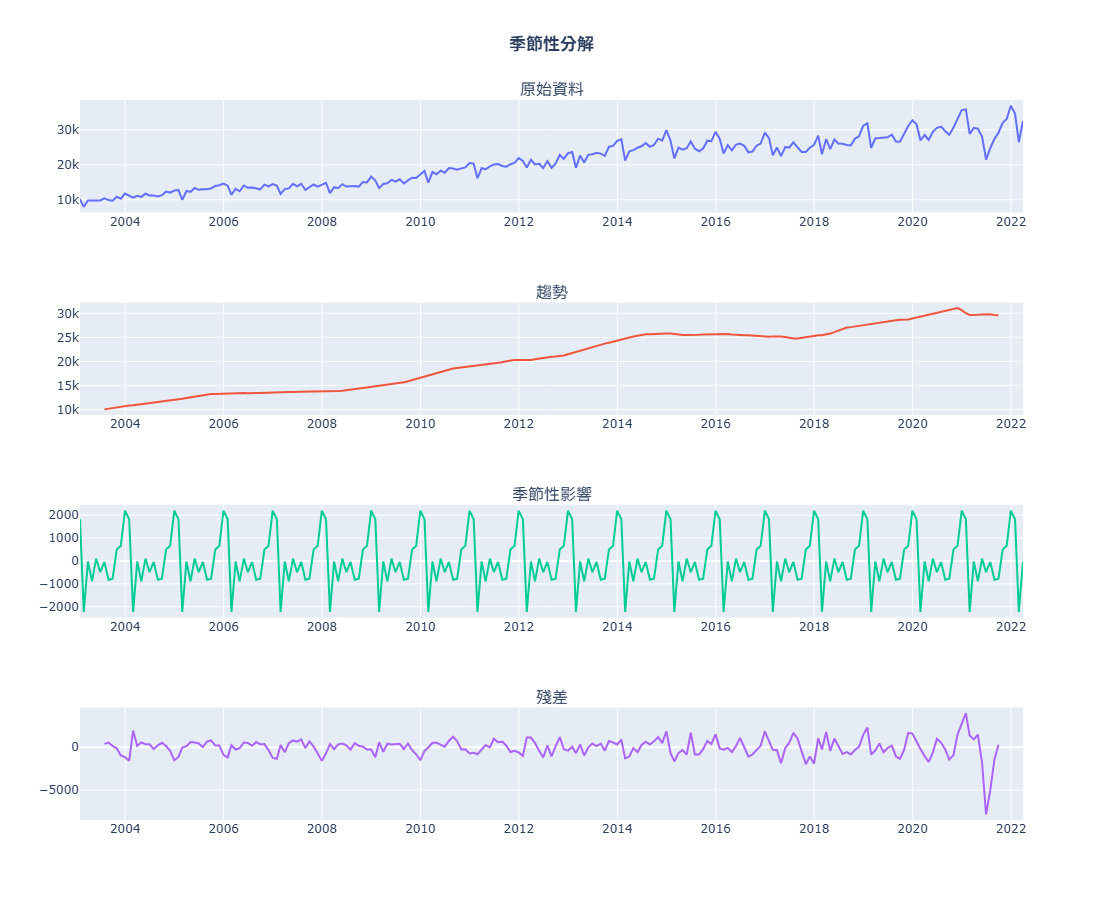

In [5]:
decomp_dat = dat.set_index('date')
decomposition = seasonal_decompose(decomp_dat, model='additive',period = 12)
fig = plot_seasonal_decompose(decomposition, dates=decomp_dat.index)
fig.show()

執行季節性分解的結果很明顯地證實我對原始資料的猜想，資料具有趨勢以及季節性影響，再更仔細地觀察後可以發現其季節性影響的期間為月影響，也就是 m = 12

接著我們進行模型建立以及效能驗證，我們將資料分成 training data 以及 test data ，挑選 2019 年之後的資料作為 test data

In [6]:
df = dat.set_index('date')
train_df = df[:192] ; test_df = df[192:]

繼續處理上述提到的資料擁有的逐年增加的趨勢以及季節性影響，資料為非穩定 (non-stationary) ，因此進行 1 次差分以及 m=12 季節性差分

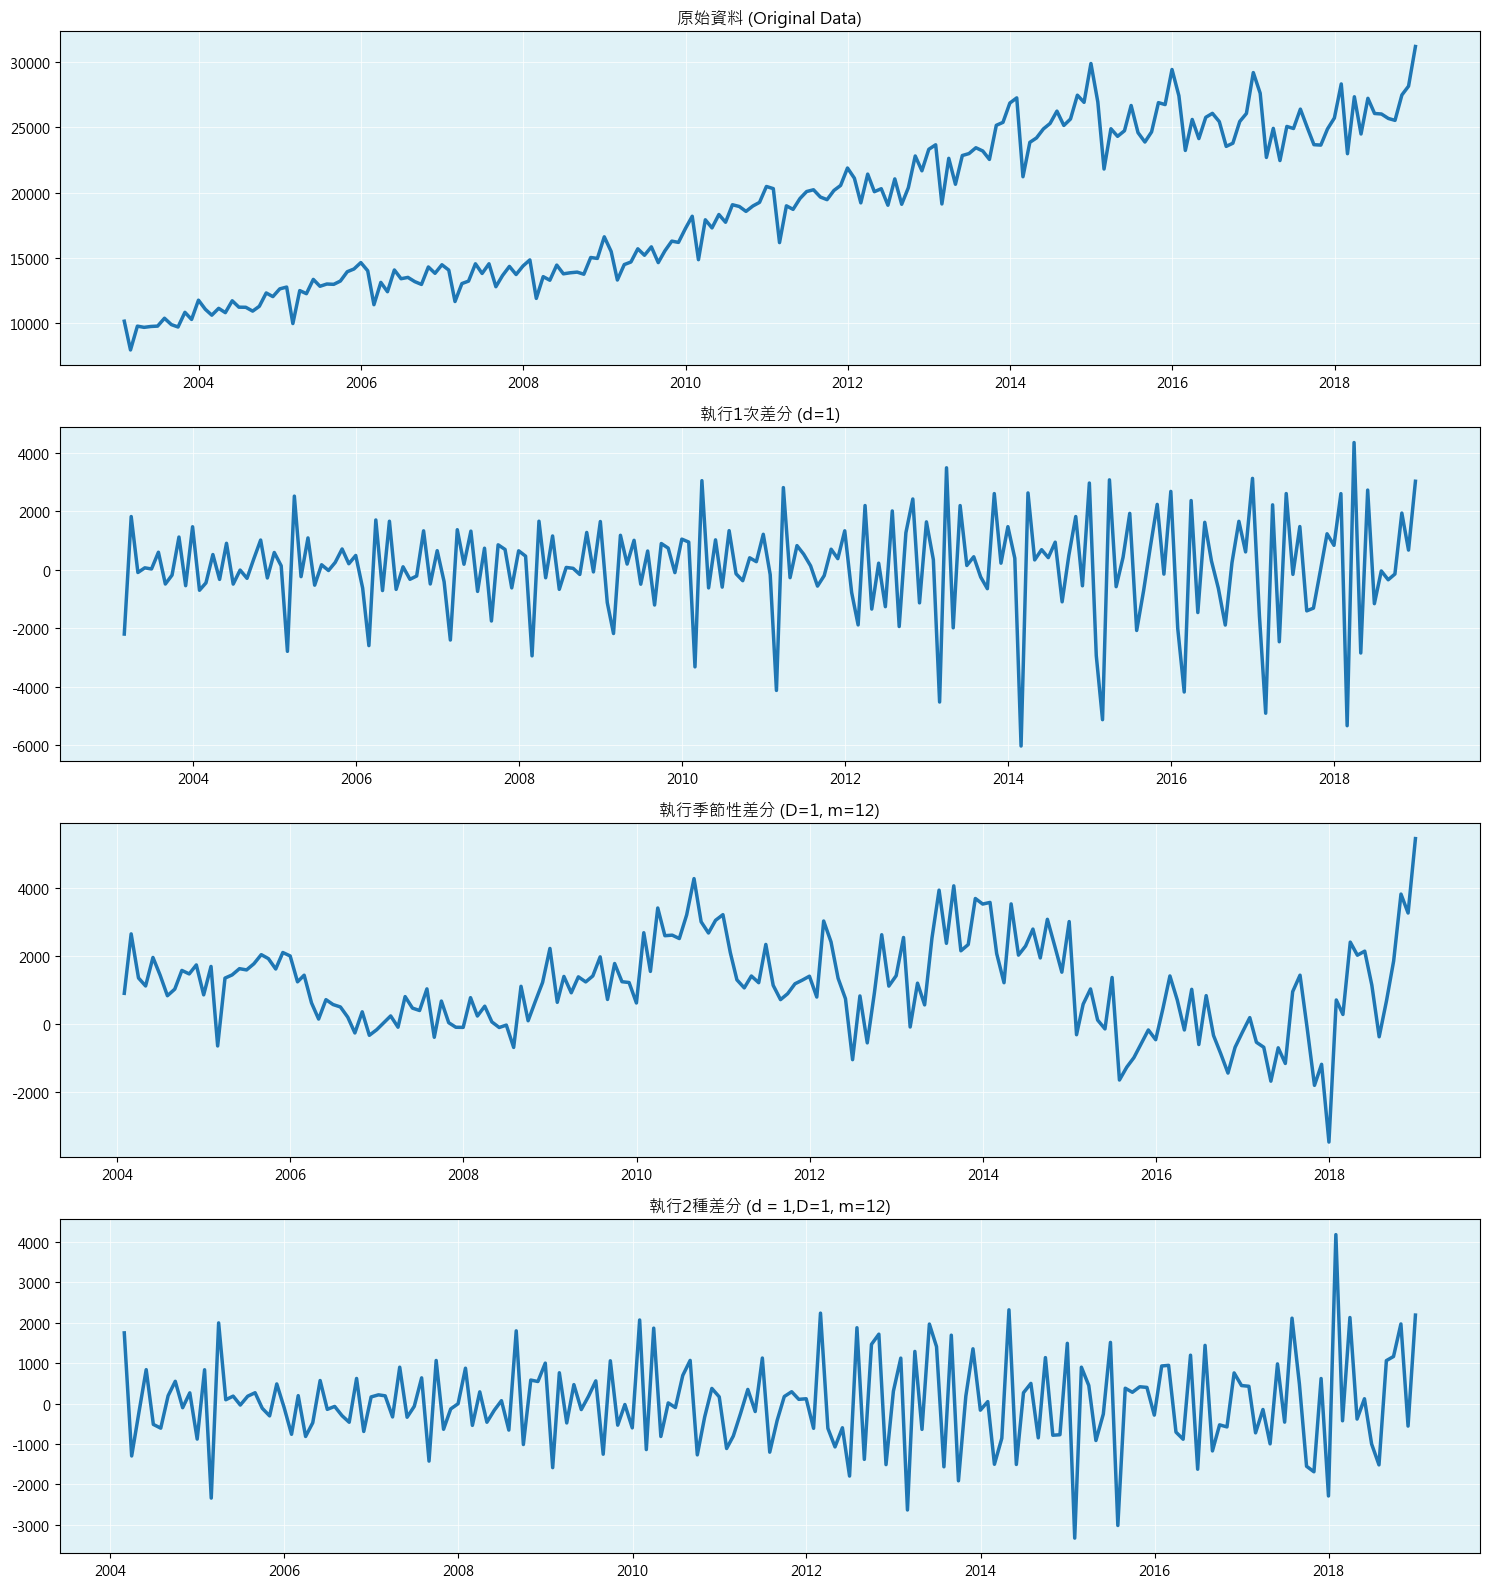

In [7]:
ts_diff = train_df.diff(1).dropna()
ts_seasonal_diff = train_df.diff(12).dropna()
ts_combined_diff = train_df.diff(1).diff(12).dropna()

fig, axes = plt.subplots(4, 1, figsize=(15, 16))
for ax in axes:
    ax.set_facecolor('#E0F2F7') # 淺藍色背景
    ax.grid(True, which='major', linestyle='-', linewidth=0.5, color='white')

# 原始資料
axes[0].plot(train_df, linewidth=2.5)
axes[0].set_title('原始資料 (Original Data)')

# 非季節性差分後的資料
axes[1].plot(ts_diff, linewidth=2.5)
axes[1].set_title('執行1次差分 (d=1)')

# 季節性差分後的資料
axes[2].plot(ts_seasonal_diff, linewidth=2.5)
axes[2].set_title('執行季節性差分 (D=1, m=12)')

# 非季節性與季節性差分後的資料
axes[3].plot(ts_combined_diff, linewidth=2.5)
axes[3].set_title('執行2種差分 (d = 1,D=1, m=12)')

plt.tight_layout()
plt.show()

從上圖表當中可以看到，原本具有趨勢並且季節性影響的原始資料，在經過其中 1 種差分之後已逐漸趨向穩定，特別是經過 2 種差分之後，資料趨向穩定的形勢更加明顯，除了分布圖之外，我也使用 Augmented Dickey-Fuller test 以及 acf 圖 pacf 圖檢測差分過的資料是否穩定。

--- 原始資料 ---
ADF 統計量: -0.0382
p-value: 0.9553


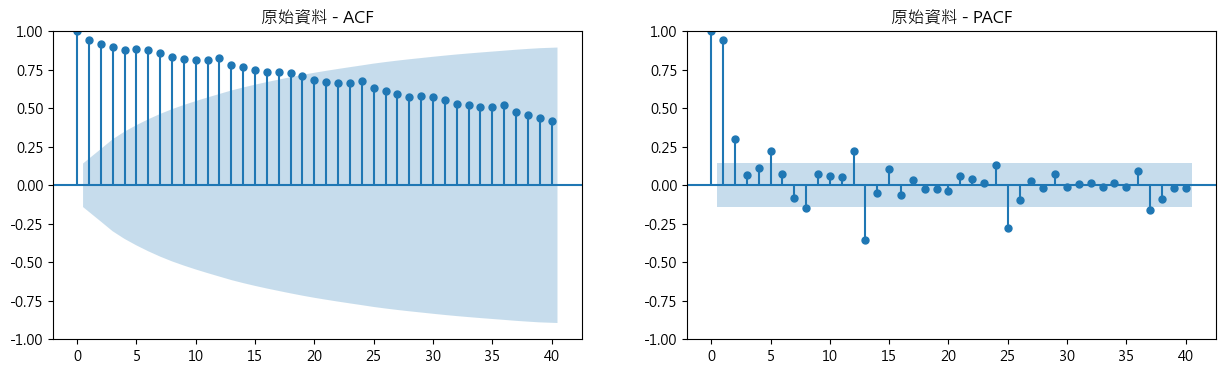



--- 執行1次差分 (d=1) ---
ADF 統計量: -3.0535
p-value: 0.0302


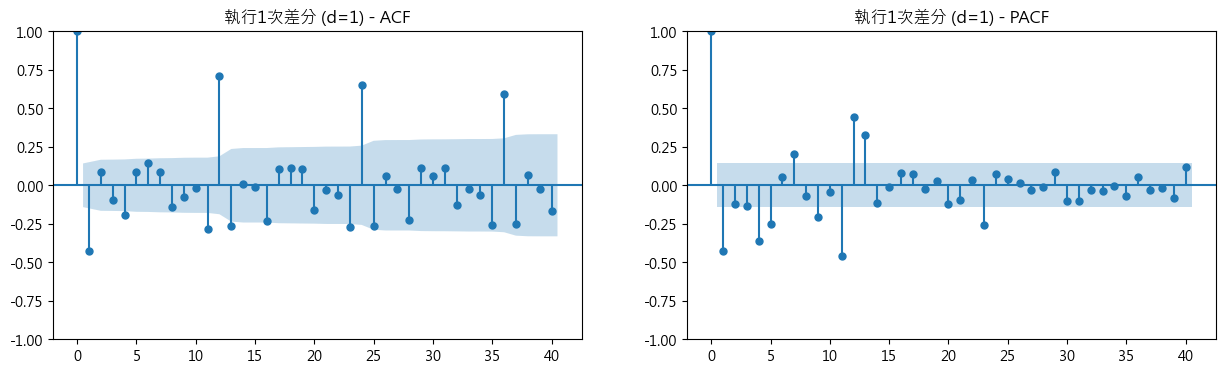



--- 執行季節性差分 (D=1, m=12) ---
ADF 統計量: -2.5966
p-value: 0.0937


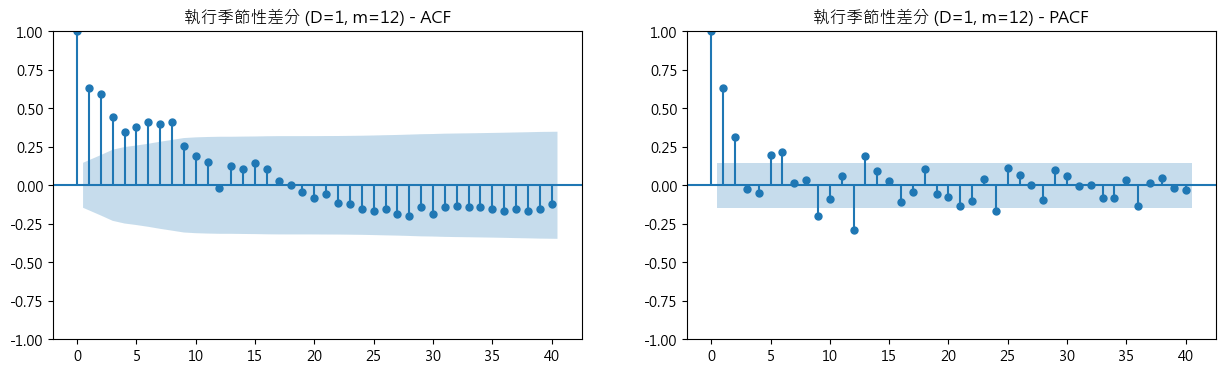



--- 執行2種差分 (d=1, D=1) ---
ADF 統計量: -3.2140
p-value: 0.0192


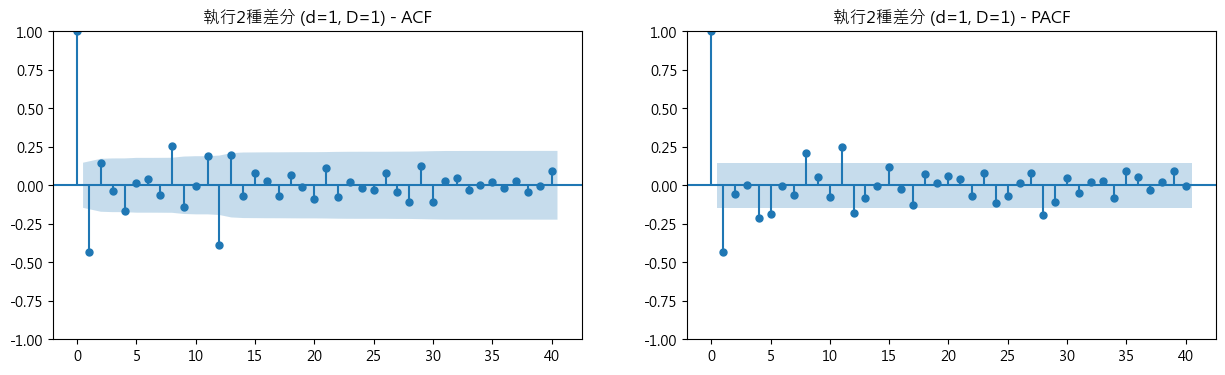

In [8]:
def check_stationarity(series, title):
    """
    執行 ADF 檢定並印出結果，同時繪製 ACF 和 PACF 圖。
    """
    print(f'--- {title} ---')
    result = adfuller(series.dropna())
    print(f'ADF 統計量: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
          
    # 繪製 ACF 和 PACF 圖
    fig, axes = plt.subplots(1, 2, figsize=(15, 4))
        
    
    plot_acf(series.dropna(), ax=axes[0], lags=40, title=f'{title} - ACF')
    plot_pacf(series.dropna(), ax=axes[1], lags=40, title=f'{title} - PACF')
    plt.show()
    print('\n')
    
check_stationarity(train_df, '原始資料')
check_stationarity(ts_diff, '執行1次差分 (d=1)')
check_stationarity(ts_seasonal_diff, '執行季節性差分 (D=1, m=12)')
check_stationarity(ts_combined_diff, '執行2種差分 (d=1, D=1)')

從上面的 8 張圖我們可以歸類出以下結論:
1. 執行 1 次差分後的 acf 以及 pacf 圖顯示 Autocorrelation 顯著降低，但在 lag = 12 的節點仍有較高的 Autocorrelation ，這表示資料仍有季節性影響
2. 執行 2 種差分後的 acf 以及 pacf 圖顯示無論 lag 節點為多少， Autocorrelation 皆顯著降低
3. 雖然無論執行 1 次差分或是 2 種差分， Augmented Dickey-Fuller test 的結果皆顯示為穩定時間序列，但從 acf 以及 pacf 圖的結果顯示 2 種差分的結果更能減少季節性影響，因此我選擇 2 種差分後的結果作為建模的資料。

### SARMAX model

在 python 當中有 pmdarima library 可以幫助進行建模挑選，在此參考上述結果，我們設定模型選取當中的差分次數固定為 1 ，季節性差分的次數也為 1 ，時期為月 m = 12 ，其餘參數使用 aic 進行選模。再者雖然該模型可以融入外在因素(3 級警戒)建立模型，但由於該事件為突發事件，難以保證再次出現，並且太過靠近資料末期，因此不納入建模。

In [9]:
sarma_model = pm.auto_arima(train_df,
                          start_p=0, start_q=0,
                          max_p=5, max_q=5,
                          m=12,# 季節性週期，這裡設為12（例如：年度）
                          start_P=0, start_Q=0,
                          max_P=5, max_Q=5,
                          seasonal=True,
                          d = 1,    
                          D = 1,
                          stepwise=True,
                          suppress_warnings=True,
                          error_action='ignore',
                          information_criterion='aic')

我們可繼續使用 plot_diagnostics 檢驗模型結果

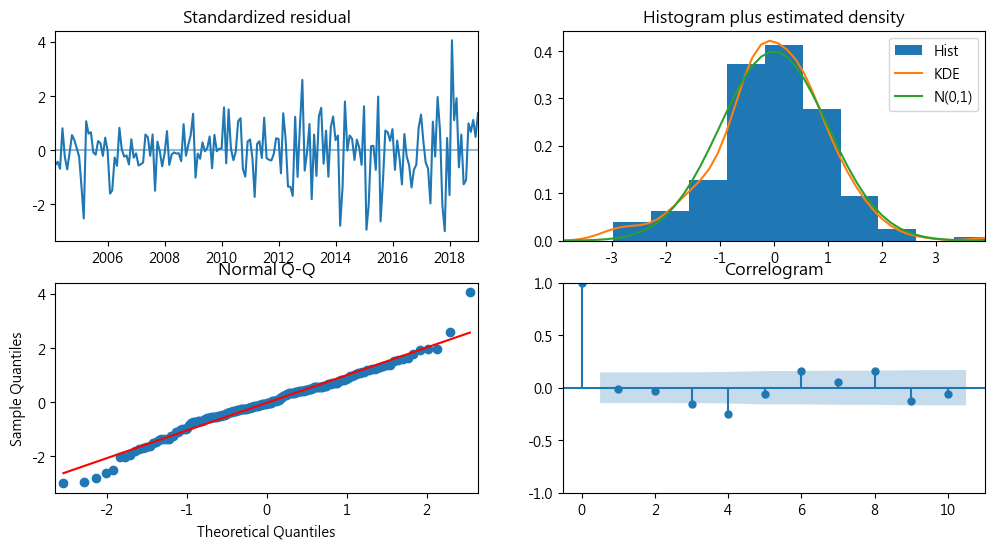

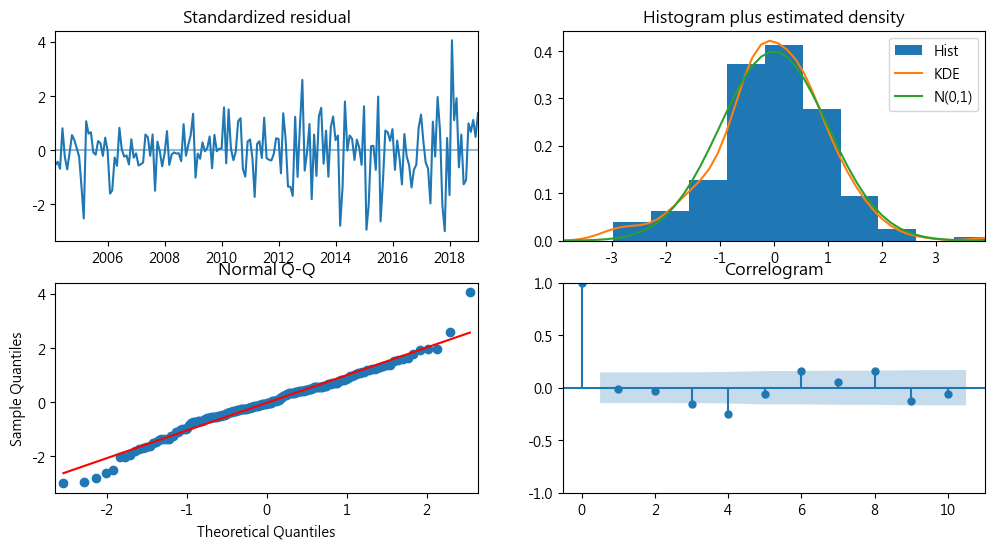

In [10]:
sarma_model.plot_diagnostics(figsize=(12,6))

圖中 Standardized Residuals 大致在 0 附近跳動並且沒有明顯趨勢， Histogram plus KDE estimate 接近標準常態分配， Normal Q-Q plot 也緊密排列在直線上，Correlogram 也沒有明顯自相關的趨勢，因此可得出該模型適配表現不錯，沒有明顯缺失。接著進行預測

In [11]:
n_periods = len(test_df)
sarma_fitted, confint = sarma_model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(test_df.index[0], periods = n_periods, freq='M')
sarma_fitted_series = pd.Series(sarma_fitted, index=index_of_fc)
sarma_lower_series = pd.Series(confint[:, 0], index=index_of_fc)
sarma_upper_series = pd.Series(confint[:, 1], index=index_of_fc)

畫出預測結果以及 95% 信賴區間

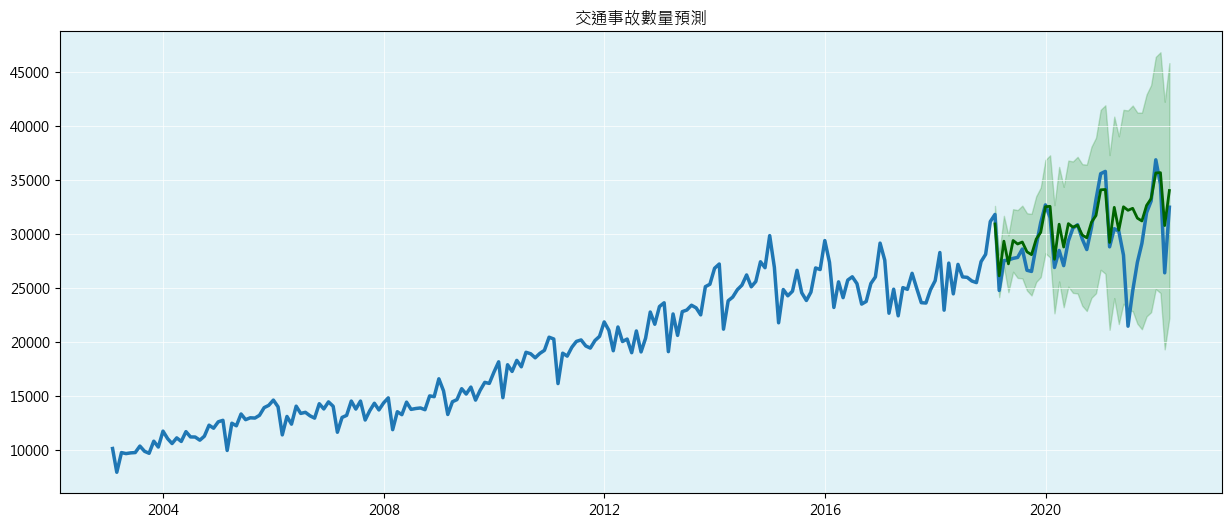

In [12]:
plt.figure(figsize=(15,6))
plt.plot(df,linewidth = 2.5)
plt.plot(sarma_fitted_series, color='darkgreen',linewidth = 2.)
plt.fill_between(sarma_lower_series.index, 
                 sarma_lower_series, 
                 sarma_upper_series, 
                 color='green', alpha=.20)

plt.title("交通事故數量預測")
ax = plt.gca()
ax.set_facecolor('#E0F2F7')
ax.grid(True, which='major', linestyle='-', linewidth=0.5, color='white')
plt.show()

預測值良好的抓住了資料的未來趨勢。接著算出預測結果的誤差

In [13]:
print(f"MSE: {mean_squared_error(test_df,sarma_fitted):.4f}")
print(f"MAE: {mean_absolute_error(test_df,sarma_fitted):.4f}")

MSE: 7234476.7860
MAE: 1737.3508


### Random forest

接著使用隨機森林進行預測，由於隨機森林沒有自動處理具有時間序資料的能力，因此自行建立訓練模型時所需的資料集。加上已知資料有 1 次差分以及季節性差分的影響，所以我建立了滯後 1 期以及滯後 12 期的資料作為特徵，除此之外也建立時間資料進行特徵。

In [17]:
def create_features(data, label=None):
    """
    Creates time series features from datetime index
    """
    data['date'] = data.index
    data['quarter'] = data['date'].dt.quarter
    data['month'] = data['date'].dt.month
    data['year'] = data['date'].dt.year
    data['dayofyear'] = data['date'].dt.dayofyear
    data['weekofyear'] = data['date'].dt.isocalendar().week
    # 使用12月前的資料
    data['amount_lag_1'] = data['amount'].shift(1)
    data['amount_lag_12'] = data['amount'].shift(12)
    X = data[['quarter','month','year',
           'dayofyear','weekofyear','amount_lag_1','amount_lag_12']]
    
    if label:
        y = data[label]
        return X, y
    return X

In [18]:
pre_X_train, pre_y_train = create_features(train_df,'amount')
X_train = pre_X_train.dropna() ; y_train = pre_y_train.loc[X_train.index]
X_test, y_test = create_features(test_df,'amount')
tscv = TimeSeriesSplit(n_splits=5)

使用時間序列的 cross validation 調控模型內參數。

In [19]:
rf_model = RandomForestRegressor(random_state=123)
rf_param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [3, 5, 10, 13],
    'min_samples_split': [2, 5, 8, 10]
}

In [20]:
rf_grid_search = GridSearchCV(
        estimator=rf_model,
        param_grid=rf_param_grid,
        # 使用負均方誤差作為評分標準
        scoring='neg_mean_squared_error',
        cv=tscv,
        n_jobs=-1,
        verbose=1
)

In [21]:
rf_grid_search.fit(X_train, y_train)
print("\n最佳參數:", rf_grid_search.best_params_)
print(f"最佳 RMSE: {(-rf_grid_search.best_score_)**0.5:.4f}")

Fitting 5 folds for each of 64 candidates, totalling 320 fits

最佳參數: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 100}
最佳 RMSE: 2116.2631


得到最佳參數後適配模型

In [22]:
rf_best_parms = rf_grid_search.best_params_
rf_final_model = RandomForestRegressor(random_state=77,**rf_best_parms)
rf_final_model.fit(X_train, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,5
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


繪製模型當中得到的特徵重要性

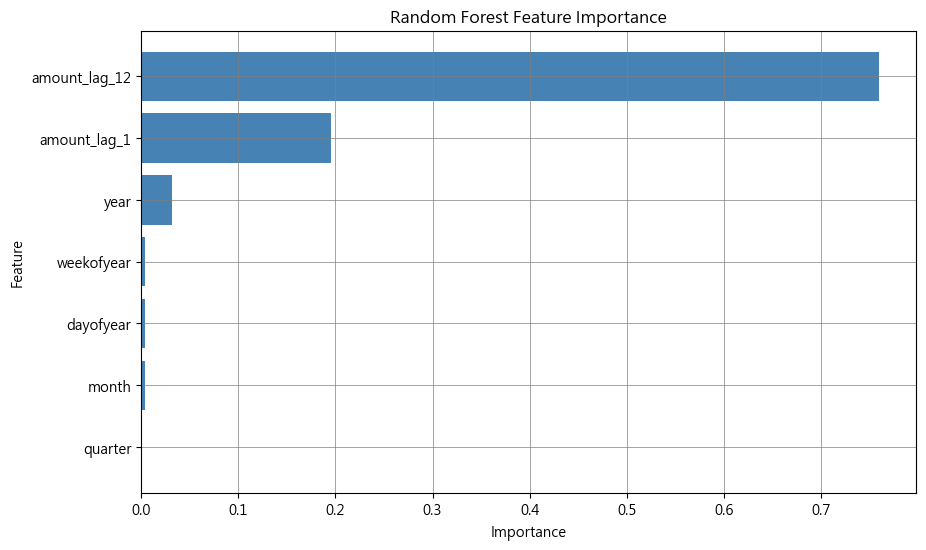

In [23]:
feature_importances = rf_final_model.feature_importances_

# 將特徵名稱和重要性配對
feature_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': feature_importances
}).sort_values(by='importance')


# --- 繪製特徵重要性圖表 ---
plt.figure(figsize=(10, 6))
ax = plt.gca()
ax.grid(True, which='major', linestyle='-', linewidth=0.5, color='gray')
plt.barh(feature_importance_df['feature'], feature_importance_df['importance'], color='steelblue')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Random Forest Feature Importance")
plt.show()

可以發現前 2 個特徵比起其餘特徵，重要性有明顯差異。

同樣地，繪製出預測結果以及計算預測誤差

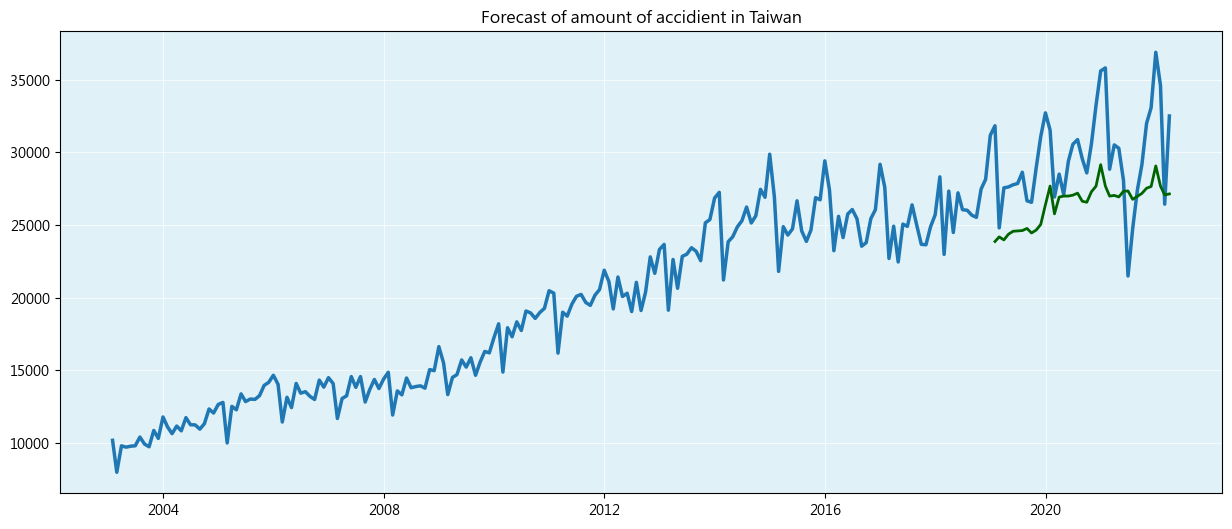

In [25]:
rf_fitted = rf_final_model.predict(X_test)
rf_fitted_series = pd.Series(rf_fitted, index=index_of_fc)
plt.figure(figsize=(15,6))
plt.plot(df,linewidth = 2.5)
plt.plot(rf_fitted_series, color='darkgreen',linewidth = 2)

plt.title("Forecast of amount of accidient in Taiwan")
ax = plt.gca()
ax.set_facecolor('#E0F2F7')
ax.grid(True, which='major', linestyle='-', linewidth=0.5, color='white')
plt.show()

In [26]:
print(f"MSE: {mean_squared_error(y_test,rf_fitted):.4f}")
print(f"MAE: {mean_absolute_error(y_test,rf_fitted):.4f}")

MSE: 17874347.4320
MAE: 3630.2877


由於上述提到特徵重要性具有明顯差異，所以我們保留前 2 個重要特徵。

In [29]:
X_train_2nd = X_train[['amount_lag_1','amount_lag_12']]
X_test_2nd  = X_test[['amount_lag_1','amount_lag_12']]

In [30]:
rf_model = RandomForestRegressor(random_state=123)
rf_param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [3, 5, 10, 13],
    'min_samples_split': [2, 5, 8, 10]
}
rf_grid_search = GridSearchCV(
        estimator=rf_model,
        param_grid=rf_param_grid,
        # 使用負均方誤差作為評分標準
        scoring='neg_mean_squared_error',
        cv=tscv,
        n_jobs=-1,
        verbose=1
)
rf_grid_search.fit(X_train_2nd, y_train)
rf_best_parms = rf_grid_search.best_params_
rf_final_model = RandomForestRegressor(random_state=77,**rf_best_parms)
rf_final_model.fit(X_train_2nd, y_train)
rf_fitted = rf_final_model.predict(X_test_2nd)
print(f"MSE: {mean_squared_error(y_test,rf_fitted):.4f}")
print(f"MAE: {mean_absolute_error(y_test,rf_fitted):.4f}")

Fitting 5 folds for each of 64 candidates, totalling 320 fits
MSE: 17097221.7593
MAE: 3309.8674


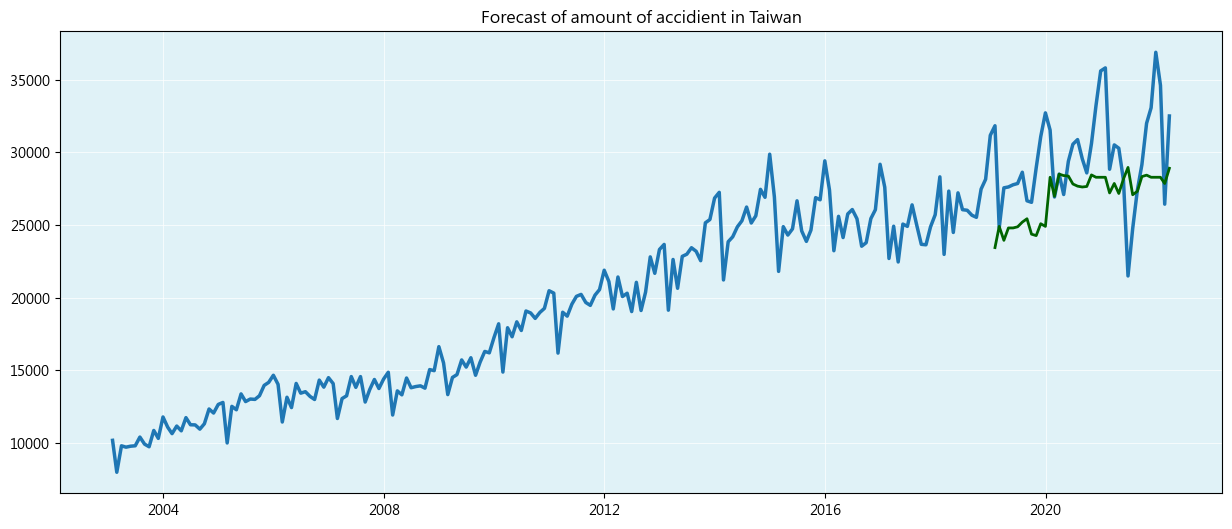

In [31]:
rf_fitted_series = pd.Series(rf_fitted, index=index_of_fc)
plt.figure(figsize=(15,6))
plt.plot(df,linewidth = 2.5)
plt.plot(rf_fitted_series, color='darkgreen',linewidth = 2)

plt.title("Forecast of amount of accidient in Taiwan")
ax = plt.gca()
ax.set_facecolor('#E0F2F7')
ax.grid(True, which='major', linestyle='-', linewidth=0.5, color='white')
plt.show()

由於第 2 個模型具有較好的預測誤差，所以我們選擇第 2 個隨機森林的模型。

### xgboost

最後，我們進行 xgboost 模型進行建模，同隨機森林模型，沒有自動處理具有時間序資料的能力，因此自行建立訓練模型時所需的資料集。
現在結合 Cross validation 對模型進行參數調控。

In [32]:
print("--- 階段 1: 尋找最佳 n_estimators ---")

# 建立模型，並設定初始參數
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    learning_rate=0.05,
    max_depth=5,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    early_stopping_rounds=50,
    n_estimators=5000, # 設定一個足夠大的數值
    eval_metric='rmse'
)

xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

best_n_estimators = xgb_model.best_iteration
print(f"找到最佳的 n_estimators: {best_n_estimators}")
print("---------------------------------------")

--- 階段 1: 尋找最佳 n_estimators ---
找到最佳的 n_estimators: 182
---------------------------------------


In [33]:
print("--- 階段 2: 調整 max_depth 和 min_child_weight ---")

# 建立模型，並將 n_estimators 設為上一步找到的最佳值
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=best_n_estimators,
    learning_rate=0.05,
    eval_metric='rmse'
)

# 設定要搜尋的參數網格
param_grid = {
    'max_depth': [3, 5, 7, 9, 11],
    'min_child_weight': [1, 3, 5, 7, 10]
}

# 使用 GridSearchCV 和 TimeSeriesSplit 進行調整
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=tscv,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

best_params_stage2 = grid_search.best_params_
print("最佳參數組合:", best_params_stage2)
print(f"最佳 RMSE: {(-grid_search.best_score_)**0.5:.4f}")
print("---------------------------------------")

--- 階段 2: 調整 max_depth 和 min_child_weight ---
Fitting 5 folds for each of 25 candidates, totalling 125 fits
最佳參數組合: {'max_depth': 5, 'min_child_weight': 1}
最佳 RMSE: 1987.1418
---------------------------------------


In [34]:
xgb_model_grid = xgb.XGBRegressor(
    objective='reg:squarederror',
    learning_rate=0.05,
    n_estimators=best_n_estimators,
    max_depth=best_params_stage2['max_depth'],
    min_child_weight=best_params_stage2['min_child_weight'],
    eval_metric='rmse'
)

param_grid_stage3 = {
    'gamma': [0.0, 0.1, 0.2],
    'subsample': [0.5,0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

grid_search_stage3 = GridSearchCV(
    estimator=xgb_model_grid,
    param_grid=param_grid_stage3,
    scoring='neg_mean_squared_error',
    cv=tscv,
    n_jobs=-1,
    verbose=1
)

grid_search_stage3.fit(X_train, y_train)

best_params_stage3 = grid_search_stage3.best_params_
print("最佳參數組合:", best_params_stage3)
print(f"最佳 RMSE: {(-grid_search_stage3.best_score_)**0.5:.4f}")

Fitting 5 folds for each of 36 candidates, totalling 180 fits
最佳參數組合: {'colsample_bytree': 1.0, 'gamma': 0.2, 'subsample': 1.0}
最佳 RMSE: 1985.2887


In [36]:
final_params = {
    'n_estimators': best_n_estimators,
    'learning_rate': 0.05,  
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    **best_params_stage2,
    **best_params_stage3
}

融合所有最佳參數進行建立模型。

In [37]:
final_model = xgb.XGBRegressor(**final_params)

# 使用完整的資料集訓練最終模型
print("\n--- 使用所有最佳參數訓練最終模型 ---")
final_model.fit(X_train, y_train)


--- 使用所有最佳參數訓練最終模型 ---


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,1.0
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'rmse'


繪製出模型中的特徵重要性，與隨機森林的模型相同的是滯後的資料都是重要特徵，不同的是其餘日期同樣具有一定重要性。

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

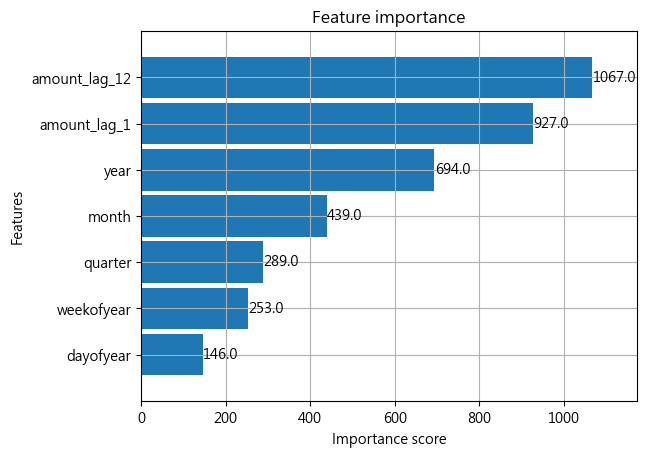

In [39]:
plot_importance(final_model,height = 0.9)

接著繪出預測結果以及算出預測誤差

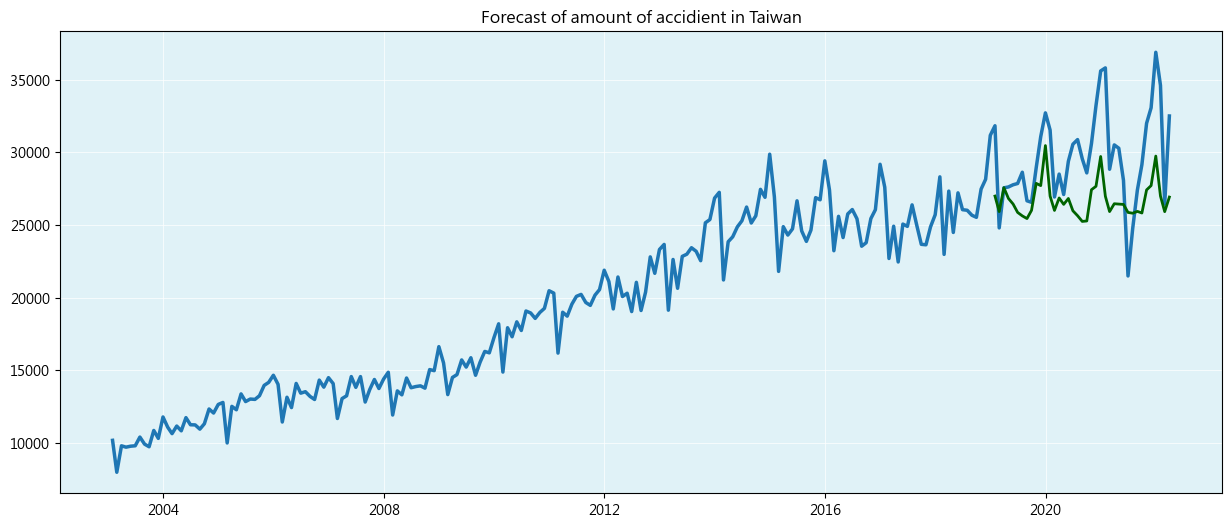

In [41]:
xgb_fitted = final_model.predict(X_test)
xgb_fitted_series = pd.Series(xgb_fitted, index=index_of_fc)
plt.figure(figsize=(15,6))
plt.plot(df,linewidth = 2.5)
plt.plot(xgb_fitted_series, color='darkgreen',linewidth = 2)

plt.title("Forecast of amount of accidient in Taiwan")
ax = plt.gca()
ax.set_facecolor('#E0F2F7')
ax.grid(True, which='major', linestyle='-', linewidth=0.5, color='white')
plt.show()

In [42]:
print(f"MSE: {mean_squared_error(y_test,xgb_fitted):.4f}")
print(f"MAE: {mean_absolute_error(y_test,xgb_fitted):.4f}")

MSE: 15086263.3031
MAE: 3238.0806


## 3 種模型比較

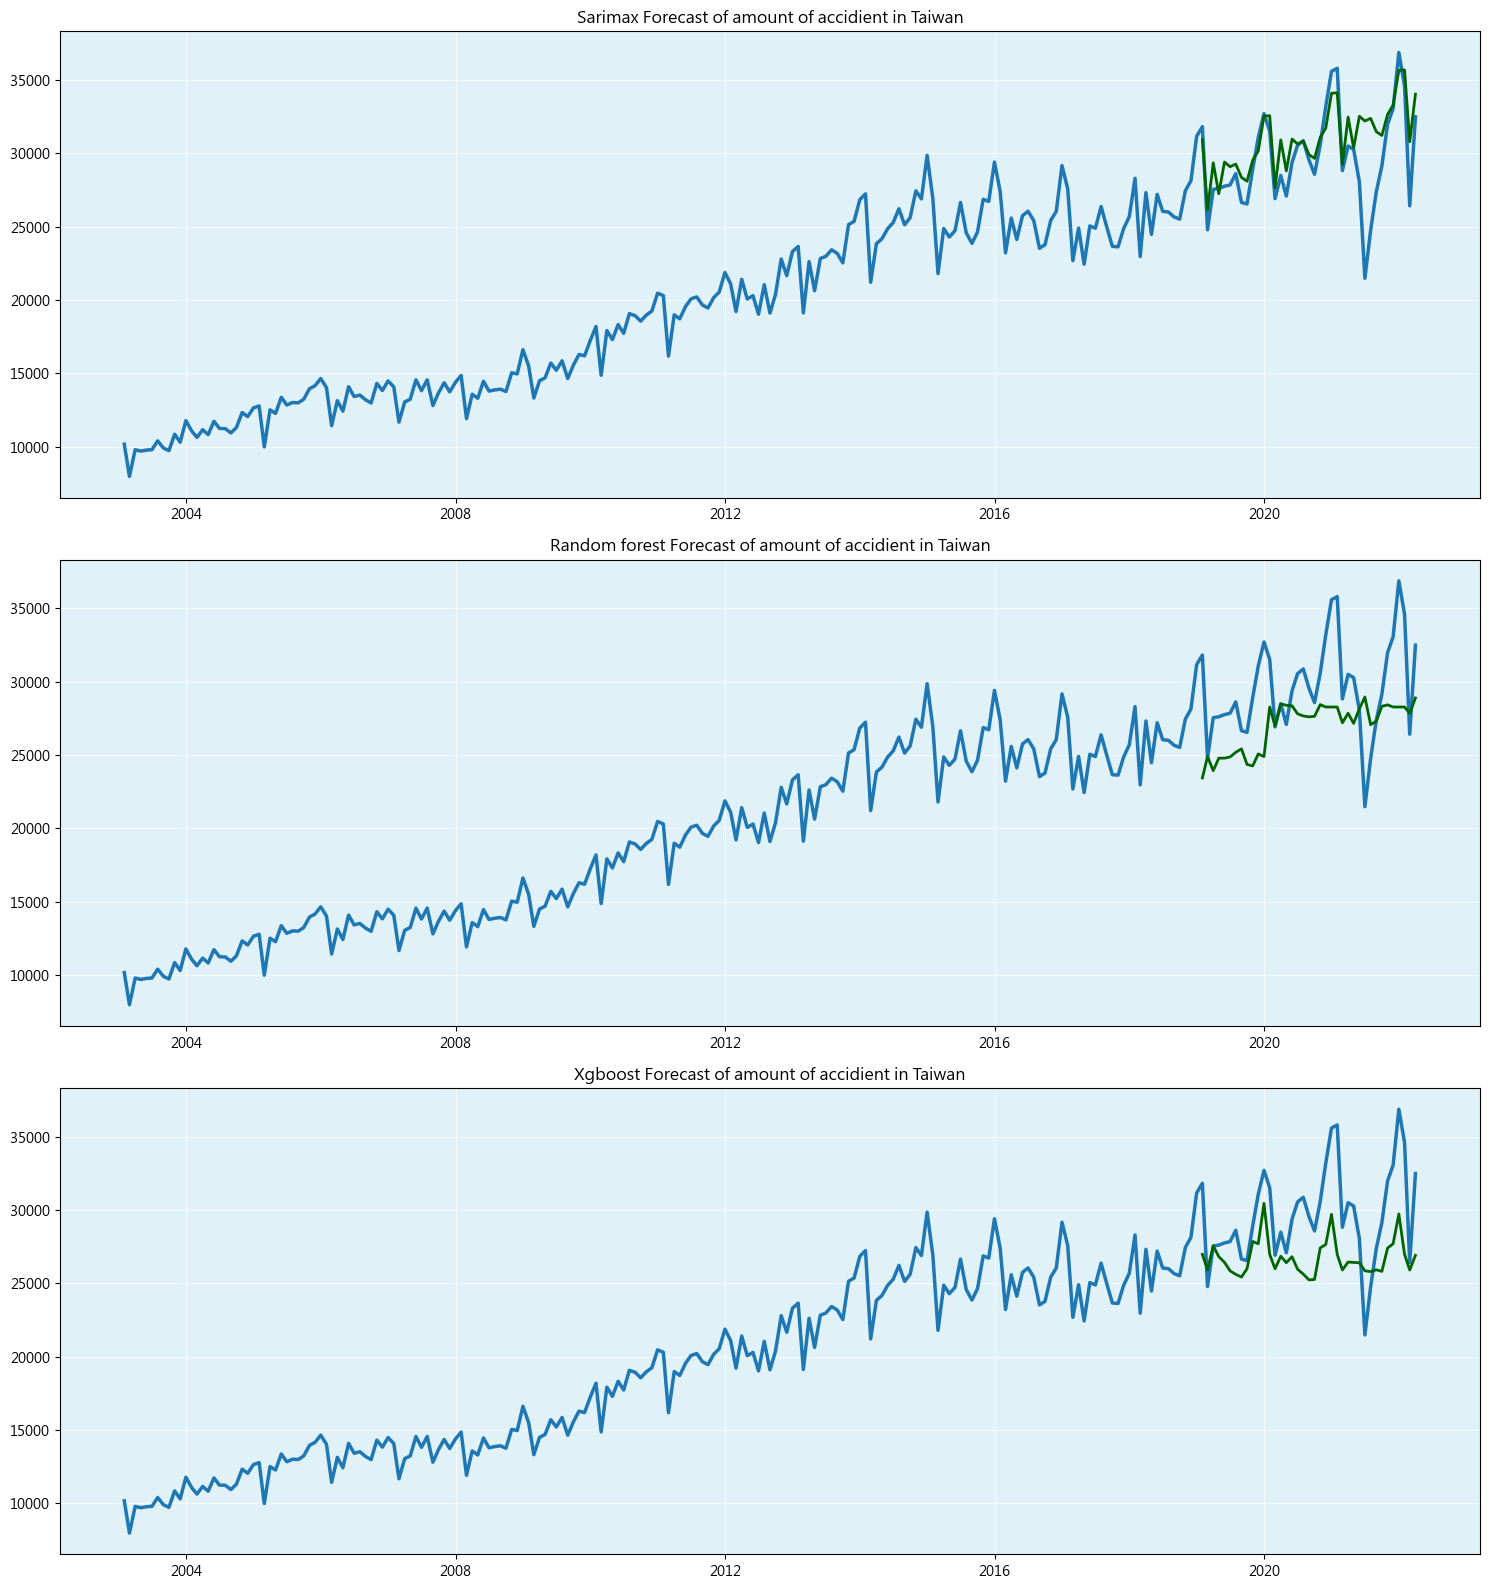

In [45]:
fig, axes = plt.subplots(3, 1, figsize=(15, 16))

for ax in axes:
    ax.set_facecolor('#E0F2F7') # 淺藍色背景
    ax.grid(True, which='major', linestyle='-', linewidth=0.5, color='white')

axes[0].plot(df,linewidth = 2.5)
axes[0].plot(sarma_fitted_series, color='darkgreen',linewidth = 2)
axes[0].set_title("Sarimax Forecast of amount of accidient in Taiwan")


axes[1].plot(df,linewidth = 2.5)
axes[1].plot(rf_fitted_series, color='darkgreen',linewidth = 2)
axes[1].set_title("Random forest Forecast of amount of accidient in Taiwan")


axes[2].plot(df,linewidth = 2.5)
axes[2].plot(xgb_fitted_series, color='darkgreen',linewidth = 2)
axes[2].set_title("Xgboost Forecast of amount of accidient in Taiwan")

plt.tight_layout()
plt.show()

In [58]:
results = {
    'SARIMA': {
        'MSE': mean_squared_error(y_test, sarma_fitted),
        'MAE': mean_absolute_error(y_test, sarma_fitted)
    },
    'RandomForest': {
        'MSE': mean_squared_error(y_test, rf_fitted),
        'MAE': mean_absolute_error(y_test, rf_fitted)
    },
    'XGBoost': {
        'MSE': mean_squared_error(y_test, xgb_fitted),
        'MAE': mean_absolute_error(y_test, xgb_fitted)
    }
}

# 轉換成 DataFrame
results_df = pd.DataFrame(results).T

# 格式化輸出，使結果更易讀
results_df['MSE'] = results_df['MSE'].map('{:.4f}'.format)
results_df['MAE'] = results_df['MAE'].map('{:.4f}'.format)

print(results_df)

                        MSE        MAE
SARIMA         7234476.7860  1737.3508
RandomForest  17097221.7593  3309.8674
XGBoost       15086263.3031  3238.0806


可以從上面的比較結果當中得知，SARIMA 模型具有最好的結果，相較於其餘 2 模型，SARIMA 更完整的擷取資料的趨勢，因此導致了預測結果差異。

最後我們使用SARIMA模型預測未來 36 個月的資料結果。

In [61]:
final_sarma_model = pm.auto_arima(df,
                          start_p=0, start_q=0,
                          max_p=5, max_q=5,
                          m=12,# 季節性週期，這裡設為12（例如：年度）
                          start_P=0, start_Q=0,
                          max_P=5, max_Q=5,
                          seasonal=True,
                          d = 1,    
                          D = 1,
                          stepwise=True,
                          suppress_warnings=True,
                          error_action='ignore',
                          information_criterion='aic')
n_periods = 36
sarma_fitted, confint = final_sarma_model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range('2022-03-31', periods = n_periods, freq='M')
sarma_fitted_series = pd.Series(sarma_fitted, index=index_of_fc)
sarma_lower_series = pd.Series(confint[:, 0], index=index_of_fc)
sarma_upper_series = pd.Series(confint[:, 1], index=index_of_fc)

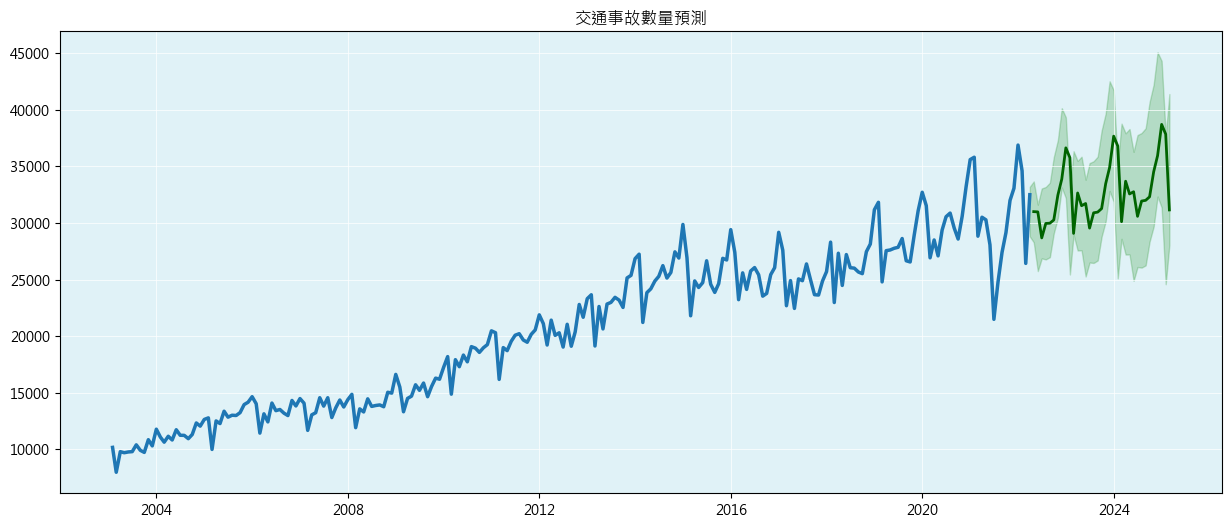

In [62]:
plt.figure(figsize=(15,6))
plt.plot(df,linewidth = 2.5)
plt.plot(sarma_fitted_series, color='darkgreen',linewidth = 2.)
plt.fill_between(sarma_lower_series.index, 
                 sarma_lower_series, 
                 sarma_upper_series, 
                 color='green', alpha=.20)

plt.title("交通事故數量預測")
ax = plt.gca()
ax.set_facecolor('#E0F2F7')
ax.grid(True, which='major', linestyle='-', linewidth=0.5, color='white')
plt.show()

可以明顯看出未來交通事故件數有明顯增加的趨勢。

臺灣近年交通事故件數的分析就到這裡，謝謝大家觀看